<a href="https://colab.research.google.com/github/Andreguimas/SeminarioAD_Jonathan_Andre/blob/main/Semin%C3%A1rioAD_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **STEP #0: Descrição do Problema**


*   Neste projeto, iremos construir, treinar e testar um modelo para classficação de itens fashion utilizando o   
TensorFlow
*   O desafio deste projeto é fazer deploy do modelo final usando o Tensorflow Serving.
*   O dataset consiste em 70000 imagens divididas em 60000 para treino e 10000 para teste. As imagens do dataset 
apresentam um tamanho 28x28 e estão a preto e branco. Todas elas têm um label associado.
*   Existem 10 classes possiveis:
  0.   T-shirt/top
  1.   Trouser
  2.   Pullover
  3.   Dress
  4.   Coat
  5.   Sandal
  6.   Shirt
  7.   Sneaker
  8.   Bag
  9.   Ankel boot

* Nota: O código apresentado de seguida é baseado em código disponibilizado na Documentação do TF serving :
     https://www.tensorflow.org/tfx/tutorials/serving/rest_simple

# **STEP #1: Importar as dependências**

In [1]:
import tensorflow as tf
import random
import json
import numpy as np
import matplotlib.pyplot as plt
import os
import tempfile

# **STEP #2: Importar o Dataset**

In [2]:
#import Fashion MNIST Dataset using keras
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


In [3]:
# Data Normalization -> Between 0 and 1
X_train = X_train / 255.0
X_test = X_test / 255.0

In [4]:
X_train.shape

(60000, 28, 28)

In [5]:
X_test.shape

(10000, 28, 28)

In [6]:
# Reshape training data to be = (6000, 28, 28 , 1)
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)

In [7]:
# Do the same for the testing dataset
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)

In [8]:
X_test.shape

(10000, 28, 28, 1)

In [9]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
              'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankel boot']

In [10]:
len(X_train)

60000

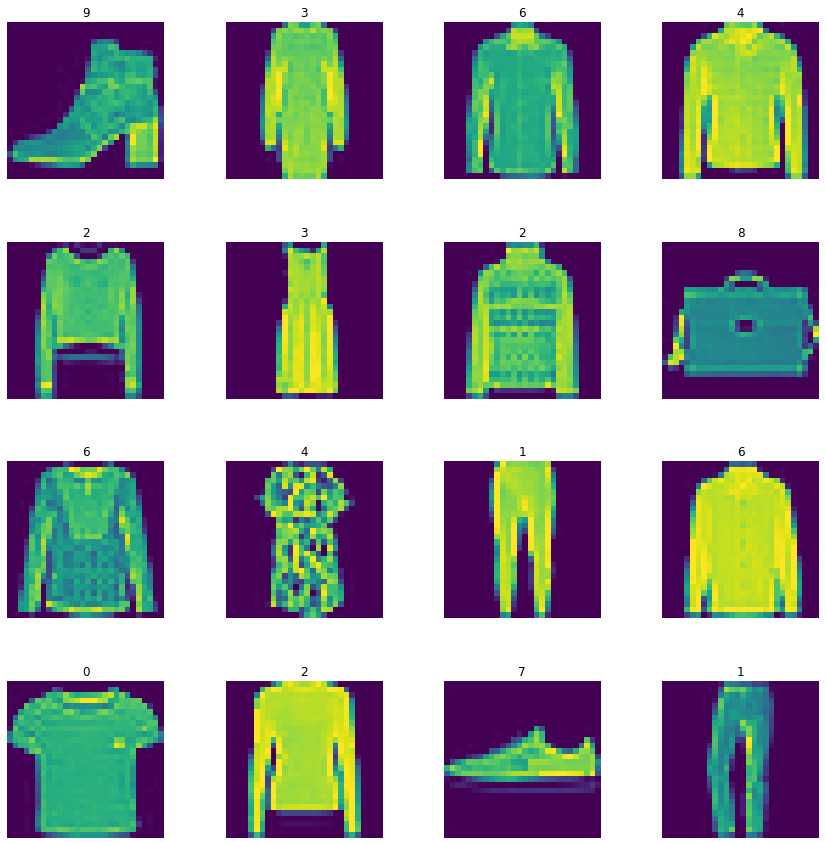

In [11]:
W_grid = 4
L_grid = 4

fig, axes = plt.subplots(L_grid, W_grid, figsize = (15, 15))
axes= axes.ravel()

n_training = len(X_train)

for i in np.arange(0, L_grid * W_grid):
    index = np.random.randint(0, n_training) # pick a random number
    axes[i].imshow(X_train[index].reshape(28,28))
    axes[i].set_title(y_train[index])
    axes[i].axis('off')
    
plt.subplots_adjust(hspace = 0.4)

# **STEP #3: Construir, Treinar e Testar o modelo**

In [12]:
cnn = tf.keras.models.Sequential()

cnn.add(tf.keras.layers.Conv2D(32, (3,3), activation = 'relu', input_shape = (28,28,1)))
cnn.add(tf.keras.layers.MaxPooling2D(2,2))

cnn.add(tf.keras.layers.Conv2D(64, (3,3), activation = 'relu'))

cnn.add(tf.keras.layers.Flatten())

cnn.add(tf.keras.layers.Dense(64, activation = 'relu'))

cnn.add(tf.keras.layers.Dense(10, activation = 'softmax'))
cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
flatten (Flatten)            (None, 7744)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                495680    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                650       
Total params: 515,146
Trainable params: 515,146
Non-trainable params: 0
__________________________________________________

In [13]:
epochs = 5

cnn.compile(optimizer=tf.keras.optimizers.Adam(),
           loss = 'sparse_categorical_crossentropy',
           metrics=['accuracy'])

In [14]:
cnn.fit(X_train, y_train, epochs=epochs)

test_loss, test_acc = cnn.evaluate(X_test, y_test)
print('\nTest accuracy: {}'.format(test_acc))

Epoch 1/5
1875/1875 [==============================] - 60s 32ms/step - loss: 0.4001 - accuracy: 0.8565
Epoch 2/5
1875/1875 [==============================] - 59s 32ms/step - loss: 0.2611 - accuracy: 0.9049
Epoch 3/5
1875/1875 [==============================] - 59s 32ms/step - loss: 0.2166 - accuracy: 0.9196
Epoch 4/5
1875/1875 [==============================] - 58s 31ms/step - loss: 0.1800 - accuracy: 0.9328
Epoch 5/5
313/313 [==============================] - 3s 9ms/step - loss: 0.2440 - accuracy: 0.9134

Test accuracy: 0.9133999943733215


# **STEP #4: Salvar o modelo**

*   Para carregar nosso modelo treinado no TensorFlow Serving, primeiro precisamos salvá-lo no formato SavedModel .
*   Isso criará um arquivo protobuf numa hierarquia de diretorias bem definida e incluirá um número de versão.
*   O TensorFlow Serving permite-nos selecionar qual a versão de um modelo queremos usar ao fazer requests.
*   Cada versão será exportada para um subdiretório diferente no caminho fornecido.
*   A função save_model oferece uma forma simples de salvar o nosso modelo:
  * tf.keras.models.save_model(
                                model, filepath, overwrite=True, include_optimizer=True, save_format=None,
                                signatures=None, options=None, save_traces=True
                                )
* Obtem mais informações em: tensorflow.org/guide/saved_model





In [15]:
#Let´s obtain a temporary storage directory
Model_Directory = tempfile.gettempdir()

In [16]:
Model_Directory

'/tmp'

In [17]:
#Let's specify the model version
version = 1

In [18]:
#Let´s join the temp model directory with our chosen version number
export_path = os.path.join(Model_Directory, str(version))
print('export_path = {}\n'.format(export_path))

export_path = /tmp/1



In [19]:
@tf.function(input_signature=[tf.TensorSpec(shape=[28,28,1], dtype=tf.float32)])
def serving(img):
    #res = tf.io.decode_jpeg(X_test[0], channels=1)
    preprocessed_img = tf.image.resize_with_pad(img, 28, 28) 
    preprocessed_img = tf.image.convert_image_dtype(preprocessed_img, tf.float32) 
    return preprocessed_img

In [20]:
#Let´s save the model using model_save
    
tf.keras.models.save_model(
    cnn,
    export_path,
    overwrite = True,
    include_optimizer=True,
    save_format=None,
    signatures= None,
    options=None
    )

INFO:tensorflow:Assets written to: /tmp/1/assets


In [21]:
#Explore MetaGraphDefs and SignatureDefs
!saved_model_cli show --dir {export_path} --all


MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['__saved_model_init_op']:
  The given SavedModel SignatureDef contains the following input(s):
  The given SavedModel SignatureDef contains the following output(s):
    outputs['__saved_model_init_op'] tensor_info:
        dtype: DT_INVALID
        shape: unknown_rank
        name: NoOp
  Method name is: 

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['conv2d_input'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 28, 28, 1)
        name: serving_default_conv2d_input:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['dense_1'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 10)
        name: StatefulPartitionedCall:0
  Method name is: tensorflow/serving/predict
W0609 17:44:50.207377 140491779164032 deprecation.py:506] From /usr/local/lib/python2.7/dist-packages/tensorflow_core/pyt

# **STEP #5: Servir o Modelo usando o TF Serving**

## **STEP #5.1: Adicionar o tensorflow-model-server package à lista de packages**

In [22]:
import sys
# We need sudo prefix if not on a Google Colab.
if 'google.colab' not in sys.modules:
  SUDO_IF_NEEDED = 'sudo'
else:
  SUDO_IF_NEEDED = ''

In [23]:
# This is the same as you would do from your command line, but without the [arch=amd64], and no sudo
# You would instead do:
# echo "deb [arch=amd64] http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal" | sudo tee /etc/apt/sources.list.d/tensorflow-serving.list && \
# curl https://storage.googleapis.com/tensorflow-serving-apt/tensorflow-serving.release.pub.gpg | sudo apt-key add -

!echo "deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal" | {SUDO_IF_NEEDED} tee /etc/apt/sources.list.d/tensorflow-serving.list && \
curl https://storage.googleapis.com/tensorflow-serving-apt/tensorflow-serving.release.pub.gpg | {SUDO_IF_NEEDED} apt-key add -
!{SUDO_IF_NEEDED} apt update

deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2943  100  2943    0     0  13256      0 --:--:-- --:--:-- --:--:-- 13256
OK
Get:1 http://storage.googleapis.com/tensorflow-serving-apt stable InRelease [3,012 B]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [697 B]
Hit:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1

## **STEP #5.2: Instalar o Tensorflow Model Server**

In [24]:
!apt-get install tensorflow-model-server

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  tensorflow-model-server
0 upgraded, 1 newly installed, 0 to remove and 48 not upgraded.
Need to get 326 MB of archives.
After this operation, 0 B of additional disk space will be used.
Get:1 http://storage.googleapis.com/tensorflow-serving-apt stable/tensorflow-model-server amd64 tensorflow-model-server all 2.5.1 [326 MB]
Fetched 326 MB in 5s (66.7 MB/s)
Selecting previously unselected package tensorflow-model-server.
(Reading database ... 160772 files and directories currently installed.)
Preparing to unpack .../tensorflow-model-server_2.5.1_all.deb ...
Unpacking tensorflow-model-server (2.5.1) ...
Setting up tensorflow-model-server (2.5.1) ...


## **STEP #5.3: Correr o Tensorflow serving**

*   Iremos carregar o nosso modelo e vamos começar a obter previsões baseadas no modelo
*   Existem alguns parametros importantes:
  * rest_api_port: Porto que será usado para os pedidos Rest
  * model_name: Iremos usar o model_name na URL dos pedidos Rest. Poderá ser escolhido qualquer nome
  * model_base_path: Este é o caminho para a pasta onde está guardado o nosso modelo



In [25]:
os.environ["Model_Directory"] = Model_Directory

In [26]:
Model_Directory

'/tmp'

In [27]:
%%bash --bg
nohup tensorflow_model_server \
  --rest_api_port=8501 \
  --model_name=CNN_Seminario \
  --model_base_path="${Model_Directory}" >server.log 2>&1

Starting job # 0 in a separate thread.


In [36]:
!tail server.log

2021-06-09 17:45:11.295890: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:190] Running initialization op on SavedModel bundle at path: /tmp/1
2021-06-09 17:45:11.307931: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:277] SavedModel load for tags { serve }; Status: success: OK. Took 136101 microseconds.
2021-06-09 17:45:11.309568: I tensorflow_serving/servables/tensorflow/saved_model_warmup_util.cc:59] No warmup data file found at /tmp/1/assets.extra/tf_serving_warmup_requests
2021-06-09 17:45:11.309783: I tensorflow_serving/core/loader_harness.cc:87] Successfully loaded servable version {name: CNN_Seminario version: 1}
2021-06-09 17:45:11.310980: I tensorflow_serving/model_servers/server_core.cc:486] Finished adding/updating models
2021-06-09 17:45:11.311087: I tensorflow_serving/model_servers/server.cc:367] Profiler service is enabled
2021-06-09 17:45:11.311709: I tensorflow_serving/model_servers/server.cc:393] Running gRPC ModelServer at 0.0.0.0:8500 .

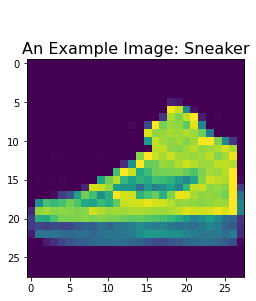

In [29]:
def show(idx, title):
  plt.figure()
  plt.imshow(X_test[idx].reshape(28,28))
  plt.title('\n\n{}'.format(title), fontdict={'size': 16})

import random
rando = random.randint(0,len(X_test)-1)
show(rando, 'An Example Image: {}'.format(class_names[y_test[rando]]))

In [38]:
import json
data = json.dumps({"signature_name": "serving_default", "instances": X_test[0:6].tolist()})
print('Data: {} ... {}'.format(data[:50], data[len(data)-52:]))

Data: {"signature_name": "serving_default", "instances": ...  [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]]]]}


In [39]:
!pip install -q requests

In [40]:
import requests

In [46]:
headers = {"content-type": "application/json"}
json_response = requests.post('http://localhost:8501/v1/models/CNN_Seminario:predict', data=data, headers=headers)
predictions = json.loads(json_response.text)['predictions']

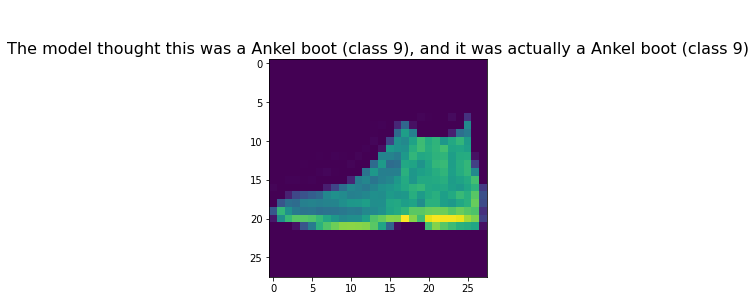

In [50]:
show(0, 'The model thought this was a {} (class {}), and it was actually a {} (class {})'.format(
  class_names[np.argmax(predictions[0])], np.argmax(predictions[0]), class_names[y_test[0]], y_test[0]))

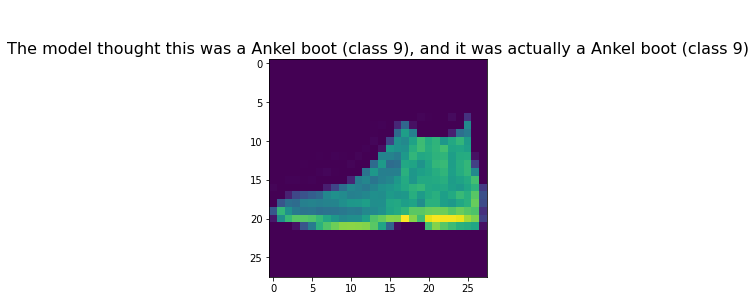

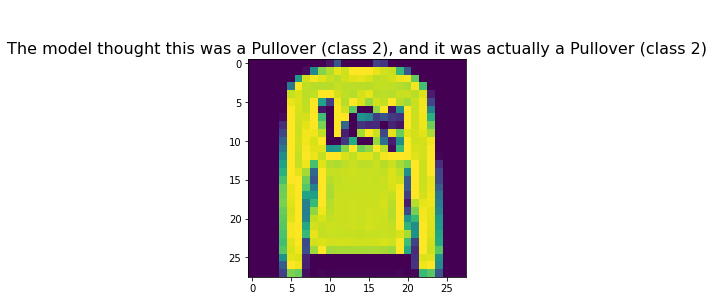

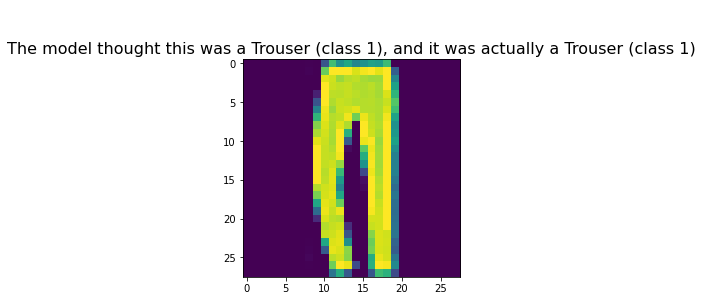

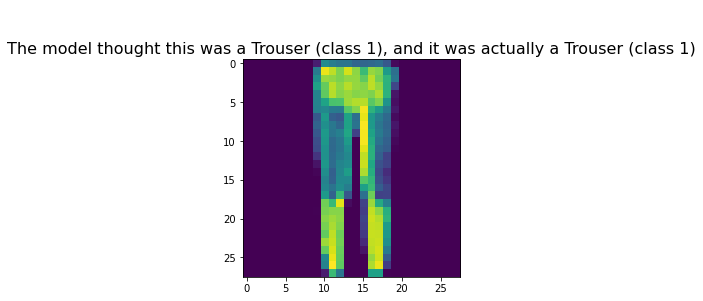

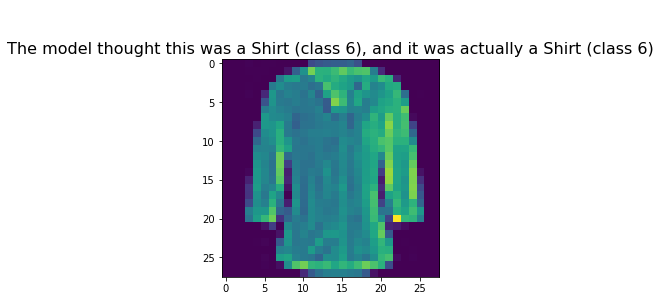

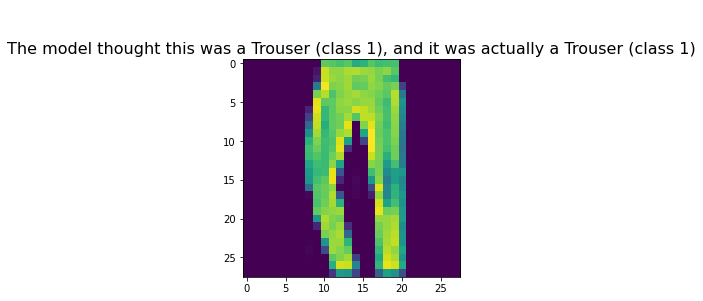

In [51]:
headers = {"content-type": "application/json"}
json_response = requests.post('http://localhost:8501/v1/models/CNN_Seminario:predict', data=data, headers=headers)
predictions = json.loads(json_response.text)['predictions']

for i in range(0,6):
  show(i, 'The model thought this was a {} (class {}), and it was actually a {} (class {})'.format(
       class_names[np.argmax(predictions[i])], np.argmax(predictions[i]), class_names[y_test[i]], y_test[i]))